In [1]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pycuda.autoinit
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
from pycuda.elementwise import ElementwiseKernel
import numpy as np
import matplotlib.pyplot as plt
from time import time

# Events

Events are generally used to provide measure time duration on the device side to precisely time operations. Events they can also be used to provide a status update for the host as to the state of a stream and what operations it has already completed, as well as for explicit stream-based synchronization.

In [ ]:
ker = SourceModule(
    """
    __global__ void mult_ker(float *array, int array_len)
    {
        int thd = blockIdx.x * blockDim.x + threadIdx.x;
        int num_iters = array_len / blockDim.x;

        for (int j = 0; j < num_iters; j++) {
            int i = j *  blockDim.x + thd;

            for (int k = 0; k < 50; k++) {
                array[i] *= 2.0;
                array[i] /= 2.0;
            }
        }
    }
    """
)

mult_ker = ker.get_function("mult_ker")

In [ ]:
array_len = 100*1024**2
data = np.random.randn(array_len).astype('float32')
data_gpu = gpuarray.to_gpu(data)

In [ ]:
start_event = drv.Event()
end_event = drv.Event()

In [ ]:
start_event.record()
mult_ker(data_gpu, np.int32(array_len), block=(64,1,1), grid=(1,1,1))
end_event.record()

In [ ]:
print(f"Has the kernel started yet?: {start_event.query()}")
print(f"Has the kernel ended yet?: {end_event.query()}")

Has the kernel started yet?: True
Has the kernel ended yet?: False


In [ ]:
end_event.synchronize()

print(f"Has the kernel started yet?: {start_event.query()}")
print(f"Has the kernel ended yet?: {end_event.query()}")

Has the kernel started yet?: True
Has the kernel ended yet?: True


In [ ]:
print(f"Kernel execution time in milliseconds: {start_event.time_till(end_event)}")

Kernel execution time in milliseconds: 1088.6639404296875


# Events and streams

In [ ]:
num_arrays = 200
array_len = 1024**2

In [ ]:
data = []
data_gpu = []
gpu_out = []
streams = []
start_events = []
end_events = []

# generate random arrays.
for _ in range(num_arrays):
    data.append(np.random.randn(array_len).astype("float32"))
    
for _ in range(num_arrays):
    streams.append(drv.Stream())
    start_events.append(drv.Event())
    end_events.append(drv.Event())

t_start = time()

for k in range(num_arrays):
    data_gpu.append(gpuarray.to_gpu_async(data[k], stream=streams[k]))

for k in range(num_arrays):
    start_events[k].record(streams[k])
    mult_ker(data_gpu[k], np.int32(array_len), block=(64,1,1), grid=(1,1,1), stream=streams[k])

for k in range(num_arrays):
    end_events[k].record(streams[k])

for k in range(num_arrays):
    gpu_out.append(data_gpu[k].get_async(stream=streams[k]))

t_end = time()

for k in range(num_arrays):
    assert (np.allclose(gpu_out[k], data[k]))

kernel_times = []
for k in range(num_arrays):
    kernel_times.append(start_events[k].time_till(end_events[k]))

print(f"Total time: {t_end - t_start}")

print(f"Mean kernel duration (milliseconds): {np.mean(kernel_times)}")
print(f"Mean kernel standard deviation (milliseconds): {np.std(kernel_times)}")

Total time: 0.4858856201171875
Mean kernel duration (milliseconds): 28.305822343826293
Mean kernel standard deviation (milliseconds): 8.61868066867474


# Synchronizing the current context

In [5]:
mandel_ker = ElementwiseKernel(
    "pycuda::complex<float> *lattice, float *mandelbrot_graph, int max_iters, float upper_bound",
    """
    mandelbrot_graph[i] = 1;
    pycuda::complex<float> c = lattice[i];
    pycuda::complex<float> z = 0.0;
    for (int j = 0; j < max_iters; j++)
    {
        z = z*z + c;
        if (abs(z) > upper_bound)
        {
            mandelbrot_graph[i] = 0;
            break;
        }
    }
    """,
    "mandel_ker"
)

def gpu_mandelbrot(width, height, real_low, real_high, imag_low, imag_high, max_iters, upper_bound):
    real_vals = np.matrix(np.linspace(real_low, real_high, width), dtype=np.complex64)
    imag_vals = np.matrix(np.linspace(imag_low, imag_high, height), dtype=np.complex64)
    mandelbrot_lattice = np.array(real_vals + imag_vals.T * 1j, dtype=np.complex64)

    # copy complex lattice to the GPU
    mandelbrot_lattice_gpu = gpuarray.to_gpu_async(mandelbrot_lattice)
    pycuda.autoinit.context.synchronize()

    # allocate an empty array on the GPU
    mandelbrot_graph_gpu = gpuarray.empty(shape=mandelbrot_lattice.shape, dtype=np.float32)

    mandel_ker(mandelbrot_lattice_gpu, mandelbrot_graph_gpu, np.int32(max_iters), np.float32(upper_bound))
    pycuda.autoinit.context.synchronize()
    mandelbrot_graph = mandelbrot_graph_gpu.get_async()
    pycuda.autoinit.context.synchronize()
    return mandelbrot_graph

It took 0.008158445358276367 seconds to calculate the Mandelbrot graph.
It took 0.020644664764404297 seconds to dump the image.


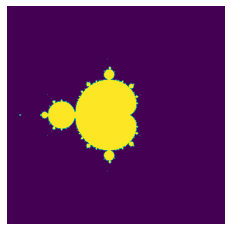

In [7]:
if __name__ == "__main__":
    t1 = time()
    mandel = gpu_mandelbrot(512,512,-2,2,-2,2,256,2)
    t2 = time()
    mandel_time = t2 - t1

    t1 = time()
    fig = plt.figure(1)
    plt.imshow(mandel, extent=(-2,2,-2,2))
    plt.axis("off")
    t2 = time()
    dump_time = t2 - t1

    print(f"It took {mandel_time} seconds to calculate the Mandelbrot graph.")
    print(f"It took {dump_time} seconds to dump the image.")

# Manual context creation

In [2]:
import numpy as np
from pycuda import gpuarray
import pycuda.driver as drv

In [3]:
drv.init()
dev = drv.Device(0)
ctx = dev.make_context()

In [4]:
x = gpuarray.to_gpu(np.float32([1,2,3]))
print(x.get())

[1. 2. 3.]


In [5]:
ctx.pop()

# Host-side multiprocessing and multithreading

Every host-side program that exists outside the operating system kernel is executed as a process, and can also exist in multiple processes. A process has its own address space, as it runs concurrently with, and independently of, all other process. A process is, generally speaking, blind to the actions of other processes, although multiple processes cna communicate through sockets or pipes.

In contrast, a host-side thread exists within a single process, and multiple threads can also exist within a single process. Multiple threads in a single process run concurrently. All threads in the same process share the same address space within the process adn have access to the same shared variables and data.

Threads are much more lightweight than processes, and it is far faster for an operating system kernel to switch tasks between multiple threads in a single process, than to switch tasks between multiple processes.

# Multiple contexts for host-side concurrency

In [6]:
import threading

In [7]:
class PointlessExampleThread(threading.Thread):
    def __init__(self):
        threading.Thread.__init__(self)
        self.return_value = None

    def run(self):
        print("Hello from the thread you just spawned")
        self.return_value = 123

    def join(self):
        threading.Thread.join(self)
        return self.return_value

In [8]:
NewThread = PointlessExampleThread()
NewThread.start()
thread_output = NewThread.join()
print(f"The thread completed and returned this value: {thread_output}")

Hello from the thread you just spawned
The thread completed and returned this value: 123


In [2]:
import pycuda
import pycuda.driver as drv
from pycuda import gpuarray
from pycuda.compiler import SourceModule
import numpy as np
from time import time
import threading

In [3]:
num_arrays = 10
array_len = 1024**2

In [4]:
kernel_code = """
__global__ void mult_ker(float *array, int array_len) {
    int thd = blockIdx.x * blockDim.x + threadIdx.x;
    int num_iters = array_len / blockDim.x;
    
    for (int j = 0; j < num_iters; j++) {
        int i = j * blockDim.x + thd;

        for (int k = 0; k < 50; k++) {
            array[i] *= 2.0;
            array[i] /= 2.0;
        }
    }
}
"""

In [5]:
class KernelLauncherThread(threading.Thread):
    def __init__(self, input_array):
        threading.Thread.__init__(self)
        self.input_array = input_array
        self.output_array = None

    def run(self):
        drv.init()
        self.dev = drv.Device(0)
        self.ctx = self.dev.make_context()
        self.ker = SourceModule(kernel_code)
        self.mult_ker = self.ker.get_function("mult_ker")

        self.array_gpu = gpuarray.to_gpu(self.input_array)
        self.mult_ker(self.array_gpu, np.int32(array_len), block=(64,1,1), grid=(1,1,1))
        self.output_array = self.array_gpu.get()
        self.ctx.pop()

    def join(self):
        threading.Thread.join(self)
        return self.output_array

In [6]:
data = []
gpu_out = []
threads = []

for _ in range(num_arrays):
    data.append(np.random.randn(array_len).astype('float32'))

for k in range(num_arrays):
    threads.append(KernelLauncherThread(data[k]))

for k in range(num_arrays):
    threads[k].start()

for k in range(num_arrays):
    gpu_out.append(threads[k].join())

for k in range(num_arrays):
    assert (np.allclose(gpu_out[k], data[k]))

# Summary

We Started this chapter by learning about device synchronization and the importance of synchronization of operations on the GPU from the host; this allows dependent operations to allow antecedent operations to finish before proceeding. 

This concept has been hidden from us, as PyCUDA has been handling synchronization for us...

We then learned about CUDA streams, which allow for independent sequences of operations to execute on the GPU simultaneously without synchronizing across the entire GPU, which can give us a big perfomrance boost; we then learned about events, which allow us to time individual CUDA kernels within a given stream, and to determine if a perticular operation in a stream has occurred. Next, we learned about contexts, which are analogous to processes in a host operating system. We learned how to synchronize across an entire CUDA context explicitly and then saw how to create and destroy contexts. Finally, we saw how we can generate multiple contexts on the GPU, to allow for GPU usage among multiple threads of processes on the host.